In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import itertools
import numpy as np
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('png')

In [0]:
def plot_data(X, y_label=None, y_pred=None, rows=5, cols=4):
    """Plot the light curve and the associated label. Trims zeroes in X"""
    plot=plt.figure(figsize=(rows * 4, 15))
    for i in range(rows * cols):
        plt.subplot(rows,cols,i+1)
        last_nonzero = np.max(np.nonzero(X[i,:,0]))
        plt.plot(X[i,:last_nonzero,0], '#a0a0a0', label='Light Curve')
        if y_label is not None:
            plt.plot(y_label[i,:last_nonzero], 'r', label='Label')
        if y_pred is not None:
            plt.plot(y_pred[i,:last_nonzero], 'b', label='Prediction')
        if i == 0:
            plt.legend()

    return plot


def plot_history(lc):
    plot=plt.figure()
    plt.plot(lc.history['f1_m'], label = 'Training F1')
    plt.plot(lc.history['val_f1_m'], label = 'Validation F1')
    plt.legend()
    return plot


def plot_curve(y_label, y_pred):
    label_cast_flat = list(itertools.chain(*y_label.astype(int)))
    pred_flat = list(itertools.chain(*y_pred))
    precision, recall, threshold = precision_recall_curve(label_cast_flat, pred_flat)
    f1 = 2 * (precision * recall) / (precision + recall)
    plot = plt.figure()
    plt.plot(threshold, precision[1:], label='Precision')
    plt.plot(threshold, recall[1:], label='Recall')
    plt.plot(threshold, f1[1:], label='F1')
    plt.legend()
    print('Best threshold: ', threshold[np.argmax(f1)-1])
    print('Best F1-Score: ', np.max(f1))
    return plot

In [0]:
import pickle

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Load MOA data
X_gb_events = pickle.load(open('/content/drive/My Drive/pTSA_microlensing/X_gb_events.p', 'rb'))

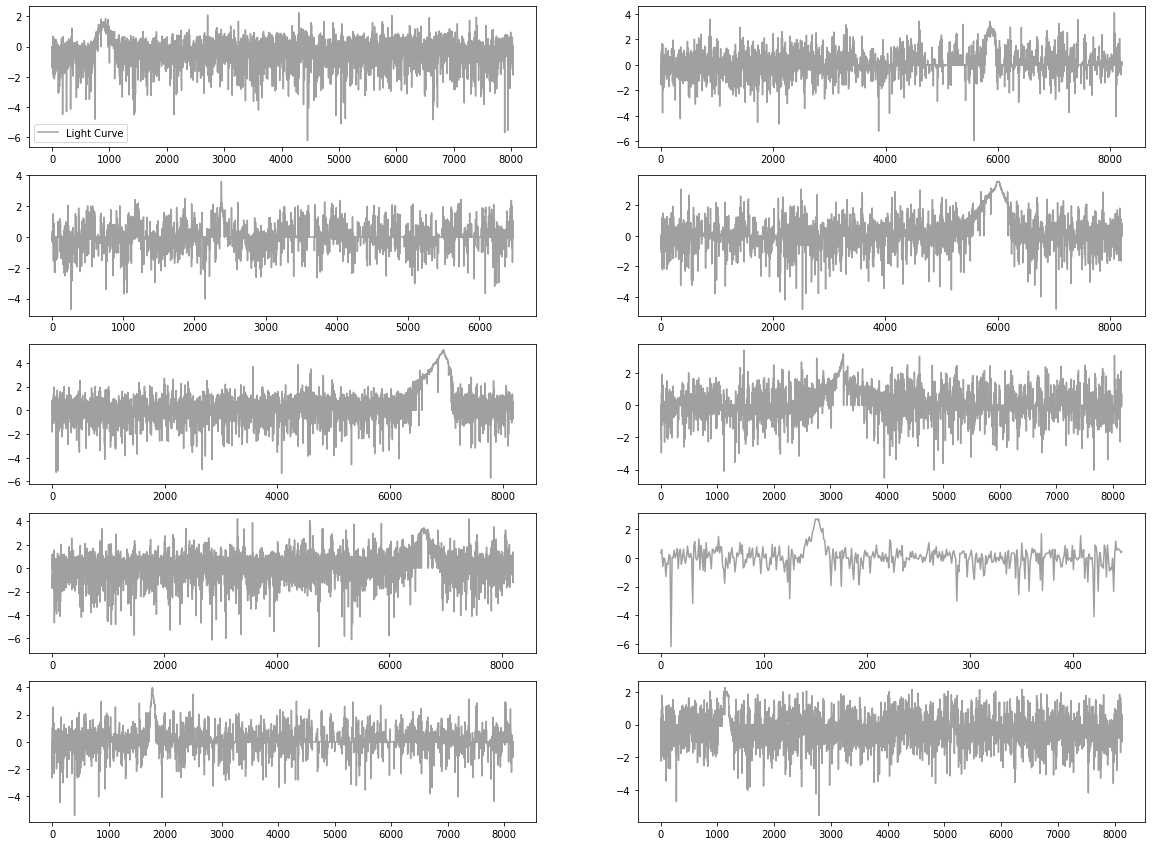

In [65]:
plot=plot_data(X_gb_events, cols=2)
plot.savefig('/content/drive/My Drive/pTSA_microlensing/graph/X_gb_events_sample.svg')
plot.show()

In [0]:
# Methods to generate simulated data.

import numpy as np
import matplotlib.pyplot as plt

def intensity_baseline(period, amplitude, phase, t):
  return amplitude * np.sin((2 * np.pi * t / period) + phase)


def lens_magnification(u0, t0, tE, t):
  ut = u0 + np.abs((t - t0) / tE)
  return (ut ** 2 + 2) / (ut * np.sqrt(ut**2 + 4))


def simulate_microlensing(baseline_period, baseline_amplitude, baseline_phase,
                          lens_min_impact, lens_shift, lens_radius, noise, t_range=range(100)):
  i_s0 = np.array([intensity_baseline(baseline_period, baseline_amplitude, baseline_phase, t) for t in t_range])
  i_A = np.array([lens_magnification(lens_min_impact, lens_shift, lens_radius, t) for t in t_range])
  n = np.random.normal(scale=noise, size=len(t_range))
  return i_s0 + i_A + n


def simulate_noevent(baseline_period, baseline_amplitude, baseline_phase, noise, t_range=range(100)):
    i_s0 = np.array([intensity_baseline(baseline_period, baseline_amplitude, baseline_phase, t) for t in t_range])
    n = np.random.normal(scale=noise, size=len(t_range))
    return i_s0 + n


from tqdm import tqdm

def generate_dataset(num_dataset, max_t=100, 
                     predict_window=30,
                     randomize_radius=False):
    X_out = np.zeros((num_dataset, max_t, 1))
    y_out = np.zeros((num_dataset, max_t))

    for x in tqdm(range(num_dataset)):
        seq=None
        ys=None
        baseline_period=np.random.uniform(low=2,high=5)
        baseline_amplitude=np.random.uniform(low=0.00008, high=0.0002)
        lens_min_impact=np.random.uniform(low=8,high=12)
        if randomize_radius:
            lens_radius=np.random.uniform(low=5,high=max_t/20)
        else:
            lens_radius=10
        if np.random.uniform() > 0.5:
            peak_t = int(np.random.uniform(low=predict_window+10, 
                                           high=max_t-predict_window-10))
            seq = simulate_microlensing(baseline_period=baseline_period, 
                                        baseline_amplitude=baseline_amplitude, 
                                        baseline_phase=0,
                                        lens_min_impact=lens_min_impact, 
                                        lens_shift=peak_t, 
                                        lens_radius=lens_radius, 
                                        noise=0.00003, 
                                        t_range=range(max_t))
            seq_avg = np.mean(seq[:predict_window])
            seq_std = np.std(seq[:predict_window])
            seq = (seq - seq_avg) / seq_std
            ys = np.zeros(max_t)
            ys[peak_t-int(lens_radius*1.5):peak_t+int(lens_radius*1.5)] = 1
        else:
            seq = simulate_noevent(baseline_period=baseline_period, 
                                   baseline_amplitude=baseline_amplitude, 
                                   baseline_phase=0,
                                   noise=0.00003,
                                   t_range=range(max_t))
            seq_avg = np.mean(seq[:predict_window])
            seq_std = np.std(seq[:predict_window])
            seq = (seq - seq_avg) / seq_std
            ys = np.zeros(max_t)
        X_out[x,:,0] = seq
        y_out[x] = ys
    
    return X_out, y_out

In [49]:
np.random.seed(100)
X_t1, y_t1 = generate_dataset(1000, max_t=500, predict_window=100, randomize_radius=False)
X_v1, y_v1 = generate_dataset(200, max_t=500, predict_window=100, randomize_radius=False)

100%|██████████| 200/200 [00:00<00:00, 467.46it/s]


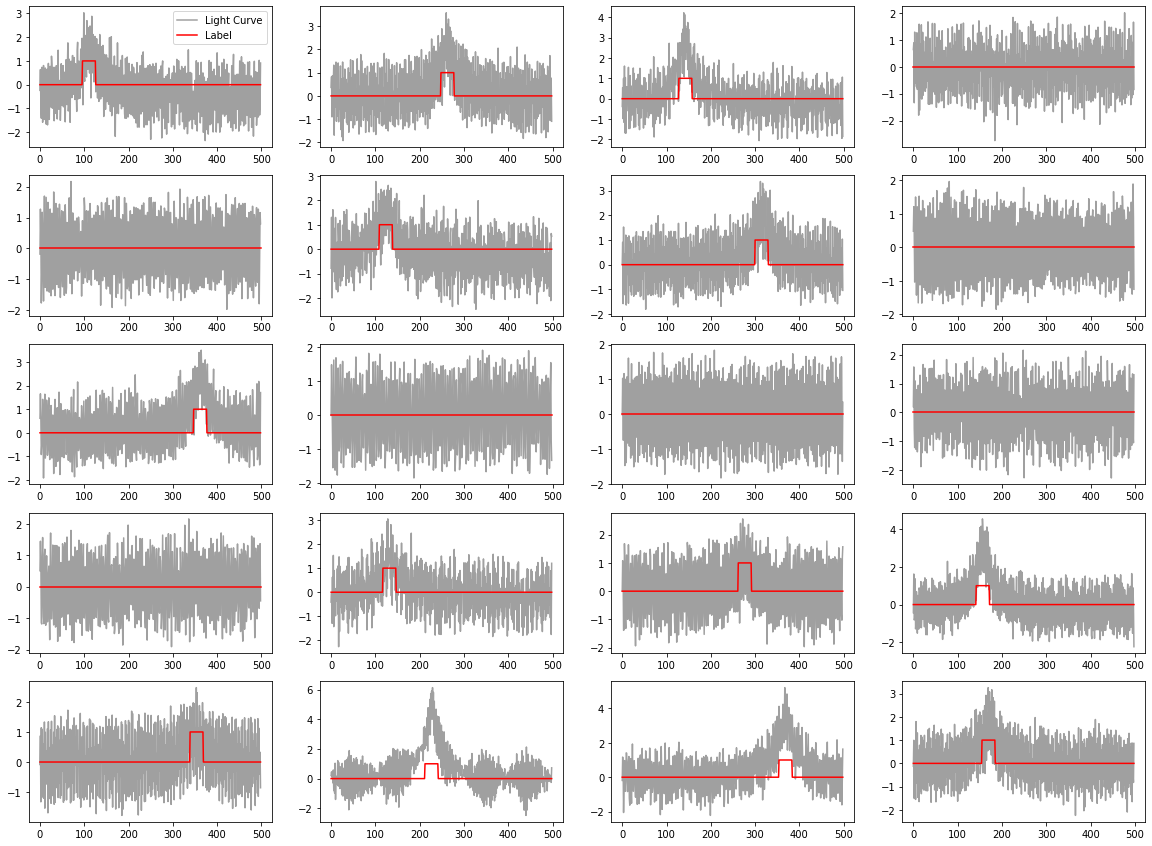

In [66]:
plot=plot_data(X_t1, y_t1)
plot.savefig('/content/drive/My Drive/pTSA_microlensing/graph/X_t1_sample.svg')
plot.show()

In [0]:
import numpy as np
import tensorflow as tf
import random as rn

def reset_seed():
    np.random.seed(42)
    rn.seed(12345)
    tf.random.set_seed(1234)

In [0]:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [53]:
import tensorflow as tf
from tensorflow.keras import layers

# GRU double layer

gru_2 = tf.keras.Sequential()

# Adding the first layer
gru_2.add(layers.GRU(units=200, return_sequences=True, input_shape=(None, 1)))
gru_2.add(layers.Dropout(0.2))

gru_2.add(layers.GRU(units=100, return_sequences=True, input_shape=(None, 200)))
gru_2.add(layers.Dropout(0.2))


# Output layer
gru_2.add(layers.Dense(units=1, activation='sigmoid'))

gru_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', f1_m])
gru_2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_8 (GRU)                  (None, None, 200)         121800    
_________________________________________________________________
dropout_8 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
gru_9 (GRU)                  (None, None, 100)         90600     
_________________________________________________________________
dropout_9 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
dense_4 (Dense)              (None, None, 1)           101       
Total params: 212,501
Trainable params: 212,501
Non-trainable params: 0
_________________________________________________________________


In [54]:
reset_seed()
lc_gru_2=gru_2.fit(X_t1, y_t1, batch_size=32, epochs=50, validation_data=(X_v1, y_v1), verbose=1, workers=4)

Train on 1000 samples, validate on 200 samples
Epoch 1/50
1000/1000 [==============================] - 6s 6ms/sample - loss: 0.2144 - acc: 0.9563 - f1_m: 0.3559 - val_loss: 0.0647 - val_acc: 0.9779 - val_f1_m: 0.4139
Epoch 2/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.0578 - acc: 0.9778 - f1_m: 0.5826 - val_loss: 0.0491 - val_acc: 0.9796 - val_f1_m: 0.5421
Epoch 3/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.0503 - acc: 0.9789 - f1_m: 0.6213 - val_loss: 0.0451 - val_acc: 0.9799 - val_f1_m: 0.5979
Epoch 4/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.0474 - acc: 0.9797 - f1_m: 0.6343 - val_loss: 0.0416 - val_acc: 0.9812 - val_f1_m: 0.6037
Epoch 5/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.0427 - acc: 0.9809 - f1_m: 0.6569 - val_loss: 0.0371 - val_acc: 0.9830 - val_f1_m: 0.6601
Epoch 6/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.0382 - acc: 0.9826 - f1

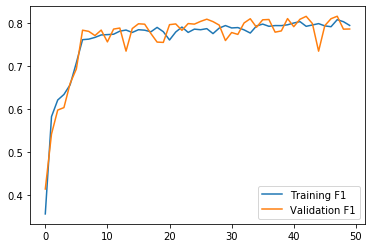

In [67]:
plot=plot_history(lc_gru_2)
plot.savefig('/content/drive/My Drive/pTSA_microlensing/graph/t1_lc.svg')
plot.show()

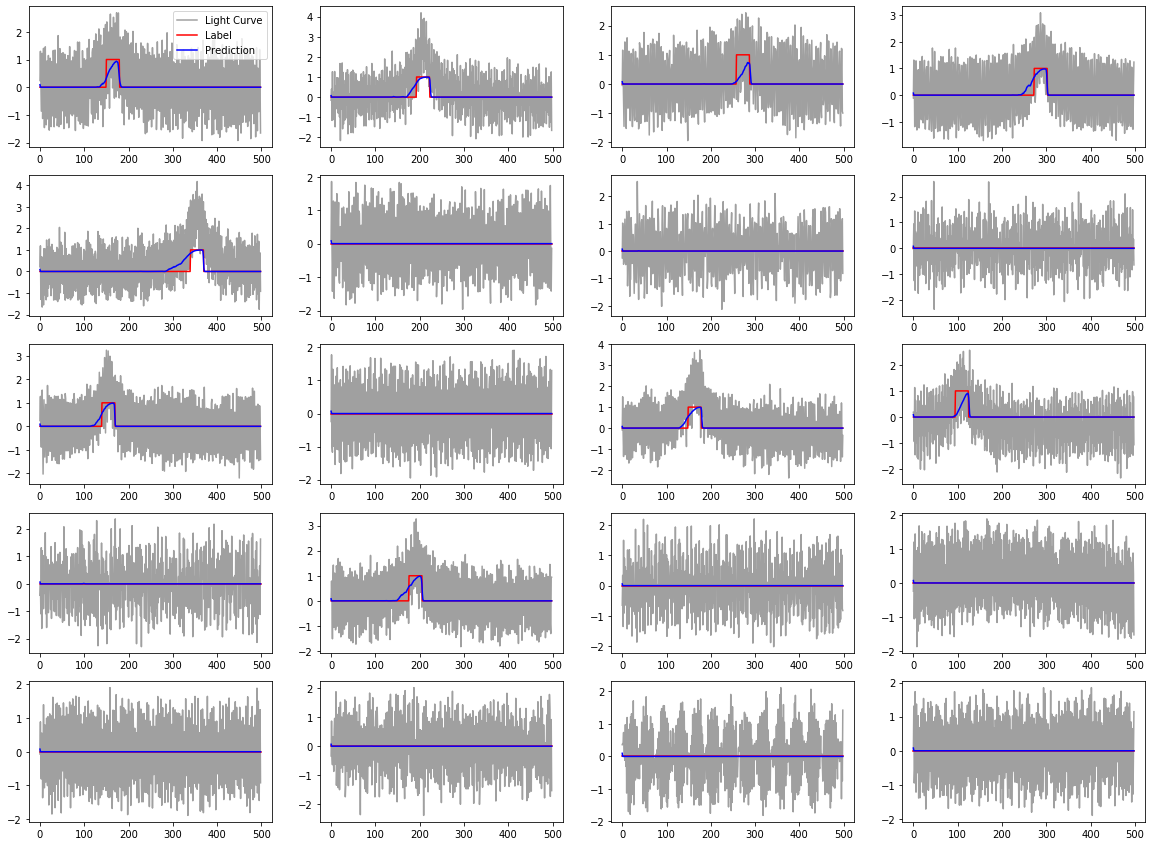

In [68]:
plot=plot_data(X_v1,y_v1,gru_2.predict_proba(X_v1))
plot.savefig('/content/drive/My Drive/pTSA_microlensing/graph/t1_val_sample.svg')
plot.show()

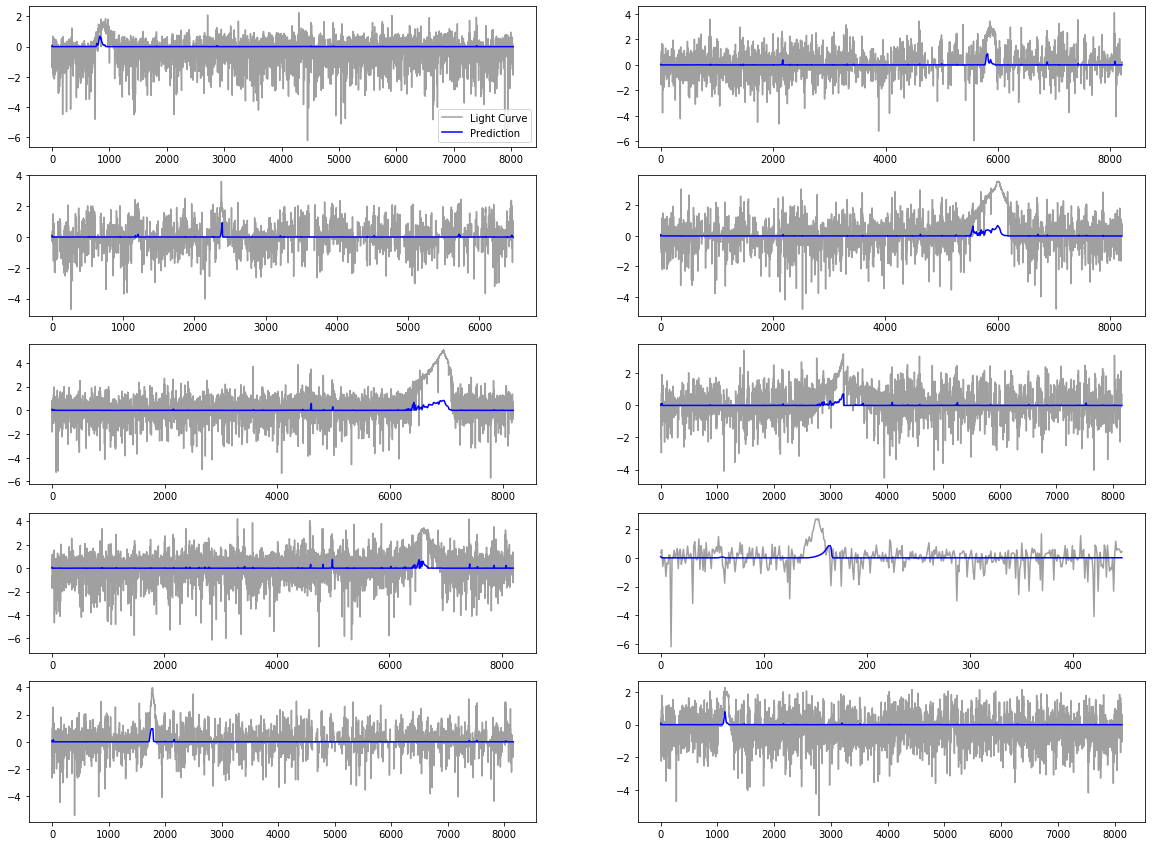

In [69]:
plot=plot_data(X_gb_events, y_pred=gru_2.predict_proba(X_gb_events), cols=2)
plot.savefig('/content/drive/My Drive/pTSA_microlensing/graph/t1_to_real.svg')
plot.show()

In [58]:
np.random.seed(100)
X_t2, y_t2 = generate_dataset(1000, max_t=500, predict_window=100, randomize_radius=True)
X_v2, y_v2 = generate_dataset(200, max_t=500, predict_window=100, randomize_radius=True)

100%|██████████| 200/200 [00:00<00:00, 437.29it/s]


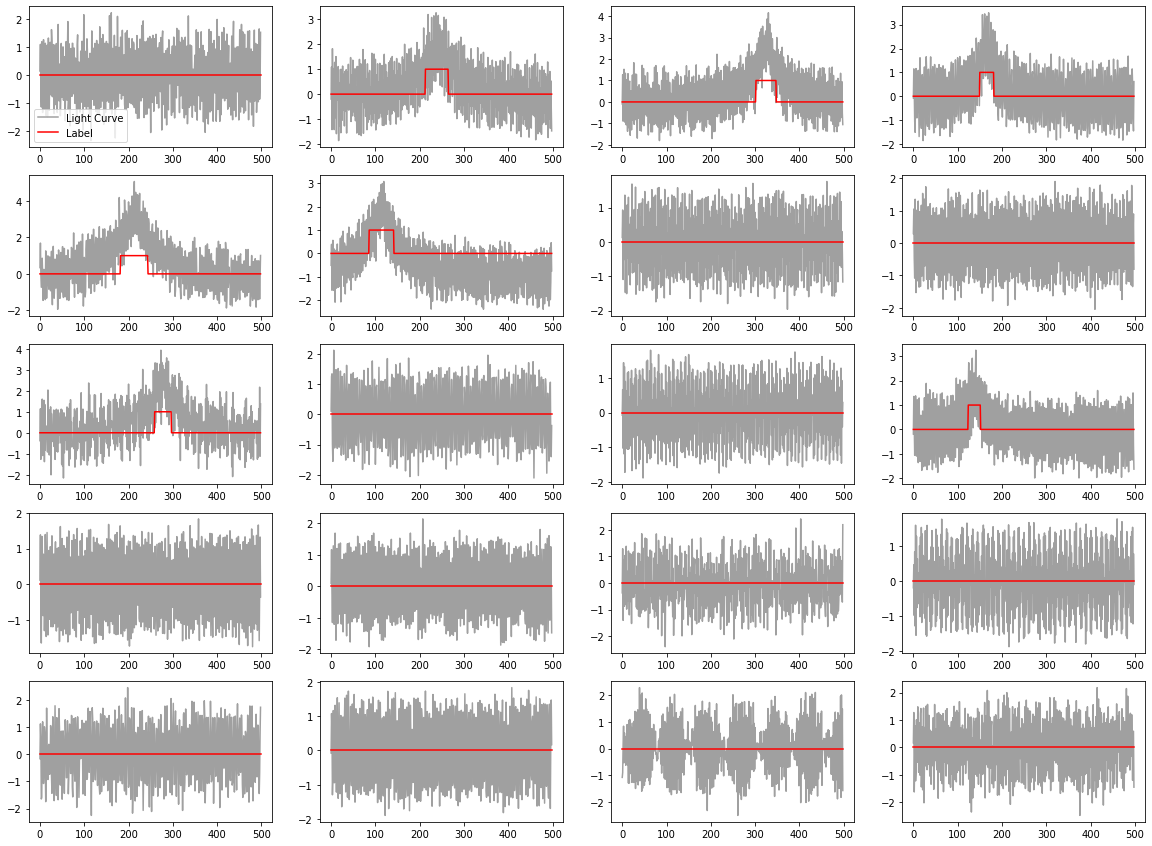

In [70]:
plot=plot_data(X_t2, y_t2)
plot.savefig('/content/drive/My Drive/pTSA_microlensing/graph/X_t2_sample.svg')
plot.show()

In [60]:
import tensorflow as tf
from tensorflow.keras import layers

# GRU double layer

gru_2_2 = tf.keras.Sequential()

# Adding the first layer
gru_2_2.add(layers.GRU(units=200, return_sequences=True, input_shape=(None, 1)))
gru_2_2.add(layers.Dropout(0.2))

gru_2_2.add(layers.GRU(units=100, return_sequences=True, input_shape=(None, 200)))
gru_2_2.add(layers.Dropout(0.2))


# Output layer
gru_2_2.add(layers.Dense(units=1, activation='sigmoid'))

gru_2_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', f1_m])
gru_2_2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_10 (GRU)                 (None, None, 200)         121800    
_________________________________________________________________
dropout_10 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
gru_11 (GRU)                 (None, None, 100)         90600     
_________________________________________________________________
dropout_11 (Dropout)         (None, None, 100)         0         
_________________________________________________________________
dense_5 (Dense)              (None, None, 1)           101       
Total params: 212,501
Trainable params: 212,501
Non-trainable params: 0
_________________________________________________________________


In [61]:
reset_seed()
lc_gru_2_2=gru_2_2.fit(X_t2, y_t2, batch_size=32, epochs=50, validation_data=(X_v2, y_v2), verbose=1, workers=4)

Train on 1000 samples, validate on 200 samples
Epoch 1/50
1000/1000 [==============================] - 7s 7ms/sample - loss: 0.2233 - acc: 0.9494 - f1_m: 0.4268 - val_loss: 0.0835 - val_acc: 0.9660 - val_f1_m: 0.5718
Epoch 2/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.0702 - acc: 0.9707 - f1_m: 0.6035 - val_loss: 0.0780 - val_acc: 0.9643 - val_f1_m: 0.6253
Epoch 3/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.0661 - acc: 0.9711 - f1_m: 0.6211 - val_loss: 0.0733 - val_acc: 0.9668 - val_f1_m: 0.6001
Epoch 4/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.0640 - acc: 0.9718 - f1_m: 0.6147 - val_loss: 0.0729 - val_acc: 0.9657 - val_f1_m: 0.6288
Epoch 5/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.0629 - acc: 0.9723 - f1_m: 0.6322 - val_loss: 0.0701 - val_acc: 0.9674 - val_f1_m: 0.6317
Epoch 6/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.0602 - acc: 0.9731 - f1

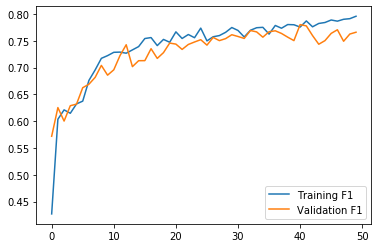

In [71]:
plot=plot_history(lc_gru_2_2)
plot.savefig('/content/drive/My Drive/pTSA_microlensing/graph/t2_lc.svg')
plot.show()

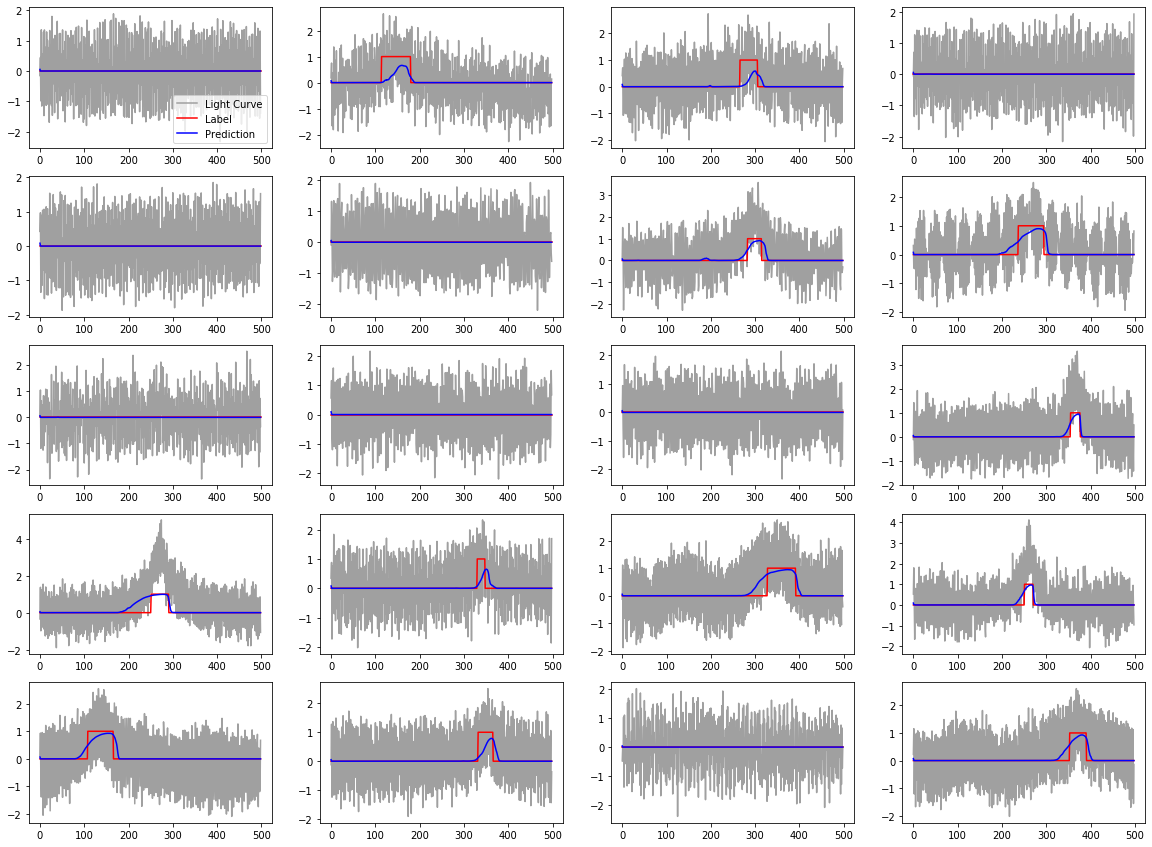

In [72]:
plot=plot_data(X_v2,y_v2,gru_2_2.predict_proba(X_v2))
plot.savefig('/content/drive/My Drive/pTSA_microlensing/graph/t2_val.sample.svg')
plot.show()

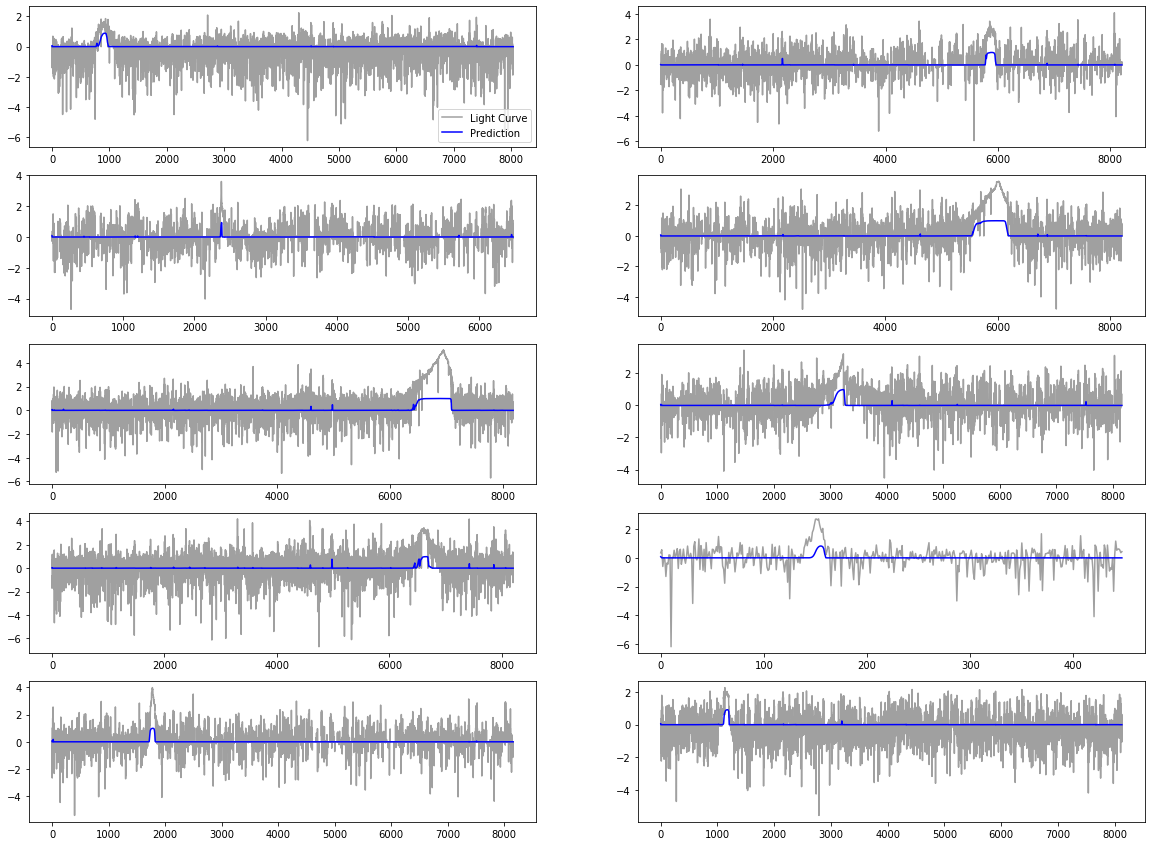

In [73]:
plot=plot_data(X_gb_events, y_pred=gru_2_2.predict_proba(X_gb_events), cols=2)
plot.savefig('/content/drive/My Drive/pTSA_microlensing/graph/t2_to_real.svg')
plot.show()

In [0]:
X_dev = pickle.load(open('/content/drive/My Drive/pTSA_microlensing/X_dev.p', 'rb'))
y_dev = pickle.load(open('/content/drive/My Drive/pTSA_microlensing/y_dev.p', 'rb'))

Best threshold:  0.27345276
Best F1-Score:  0.7249855963126561


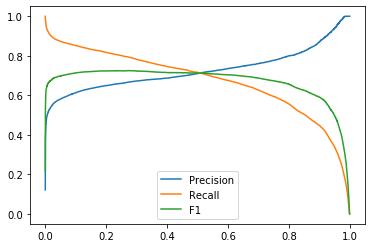

In [115]:
plot=plot_curve(y_dev, gru_2_2.predict_proba(X_dev))

In [0]:
from sklearn.metrics import f1_score


def dev_f1score(y_label, y_pred, threshold=0.5):
    label_cast_flat = list(itertools.chain(*y_label.astype(int)))
    pred_flat = [1 if p>threshold else 0 for p in list(itertools.chain(*y_pred))]
    return f1_score(label_cast_flat, pred_flat)

In [114]:
dev_f1score(y_dev ,gru_2_2.predict_proba(X_dev))

0.7130662477088244